<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M0.532 · Pattern Recognition</p>
<p style="margin: 0; text-align:right;">Computational Engineering and Mathematics Master</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Computers, Multimedia and Telecommunications Department</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

## Image Classification with Convolutional Neural Networks (CNNs): Training from scratch

In this notebook we will define a CNN architecture which will be trained from scratch on a dataset of handwritten digits. 

We first import several modules from torch library which will be used for defining our CNN architecture.

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Let's define the batch size for training and testing. We also define the transformations that will be applied to the images (ToTensor and Normalize). Finally, we prepare the training and test dataset loaders from the MNIST dataset.

In [ ]:
batch_size_train = 64
batch_size_test = 1000


data_transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/files/', train=True, download=True, transform=data_transform), 
    batch_size=batch_size_train, 
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True, transform=data_transform), 
    batch_size=batch_size_test, 
    shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



Let's see how it is a test batch. We can see how each batch is a Tensor with 4 dimensions, where the first dimension is the batch size (1000), the second dimension is the number of channels of the image (1, i.e. gray-scale image), and the third and fourth dimensions correspond to the image size (28x28 pixels). We also check the example_targets variable, which corresponds to the labels, with a size equals to the batch size (1000).

In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

print('batch size {}, canals {}, ample {}, alt {}'.format(example_data.shape[0], example_data.shape[1], example_data.shape[2], example_data.shape[3]))
print('Labels {}'.format(example_targets.shape[0]))

batch size 1000, canals 1, ample 28, alt 28
Labels 1000


We show next some image samples from MNIST dataset with their corresponding ground truth labels.

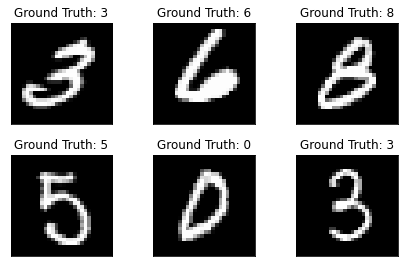

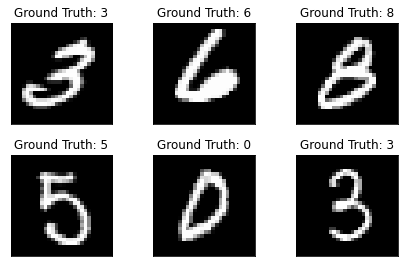

In [ ]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

Onced explored the MNIST dataset and defined the dataset loaders, we also need to define the architecture that will be used to train the model. Here, we define an architecture which consists of two convolutional layers with 5x5 kernels, followed by one Dropout layer, and finally two fully connected layers. The last fully connected layer (fc2) has as many output units and the number of categories for the image classification problem (10). Whereas in the $__init__$ function we define the different layers from our neural network architecture, in the forward function, we specify how the data will pass through our model.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        num_classes = 10
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, num_classes)
        

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

We define the values for some training parameters. In this example, we will use the SGD (Stochastic Gradient Descent) optimization method which requires to define the learning rate and momentum parameters. We also use a seed so that the experiments can be reproducible. We create an instance network of our architecture as well as the SGD optimizer. Finally, we define the loss that will be used during training. Here, we use the cross entropy loss, which is one of the most used in classification problems.

In [ ]:
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 34343
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

network = Net()

print(network)

total_params = sum(p.numel() for p in network.parameters())
print('total parameters {}'.format(total_params))

optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

criterion = nn.CrossEntropyLoss()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)
total parameters 21840


Next, we define the training procedure for our model. We need first to specify that we are using our network for training by calling the train() method of our model instance. Then, we define the operations that will be done for each training batch. First, we explicitly set the gradients to zero before starting to do backpropragation with the zero_grad method. Then, we pass our data through our network and we compute the loss. Then, we apply backpropagation with backward method. Finally, the weights of our network are updated by calling the method step from the optimizer. We also print the loss values every log_interval batches.

In [ ]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, 
                batch_idx * len(data), 
                len(train_loader.dataset), 
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())

Once the training procedure has been defined, we need to also define the test procedure. We need first to specify that we are using our network for testing by calling the eval() method of our model instance. We also initialize the loss to zero and the number of corrected predictions to zero. During testing we also need to specify that no gradients will be computed with the no_grad method from torch. Then, for each batch from the test subset, we pass the data through the network, we compute the loss by using the criterion function and update the test loss. For each test sample, we select the category with highest prediction score to know the predicted category. We compare the predicted categories with the ground truth labels to obtain the number of correct predictions. Finally, we print the loss in the test batch and the number of correct predictions.

In [ ]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += criterion(output, target)
            # test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            test_loss /= len(test_loader.dataset)
            test_losses.append(test_loss)
            print('Test set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
                test_loss, 
                correct, 
                len(test_loader.dataset),
                100. * correct / len(test_loader.dataset)))

Once defined both training and testing procedures, we proceed to train and evaluate our network. In our example, we will train our network for 3 epochs, which means that the whole dataset will be used 3 times to train the model. For each epoch, we first train the model and then we evaluate the model.

In [ ]:
n_epochs = 3
train_losses = []
test_losses = []

test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

Test set: Avg. loss: 0.0002, Accuracy: 81/10000 (1%)
Test set: Avg. loss: 0.0002, Accuracy: 176/10000 (2%)
Test set: Avg. loss: 0.0002, Accuracy: 266/10000 (3%)
Test set: Avg. loss: 0.0002, Accuracy: 359/10000 (4%)
Test set: Avg. loss: 0.0002, Accuracy: 461/10000 (5%)
Test set: Avg. loss: 0.0002, Accuracy: 565/10000 (6%)
Test set: Avg. loss: 0.0002, Accuracy: 655/10000 (7%)
Test set: Avg. loss: 0.0002, Accuracy: 754/10000 (8%)
Test set: Avg. loss: 0.0002, Accuracy: 867/10000 (9%)
Test set: Avg. loss: 0.0002, Accuracy: 980/10000 (10%)
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.355737
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.303437
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.279248
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.255536
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.281182
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.244768
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.210402
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.193094
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.193300
Train Epoch: 1 [5760/60000 (10%)

Once our model has been trained, we will show the accuracy on the test set. We will also plot the training and testing losses.

Test set: Avg. loss: 0.0000, Accuracy: 967/10000 (10%)
Test set: Avg. loss: 0.0000, Accuracy: 1938/10000 (19%)
Test set: Avg. loss: 0.0000, Accuracy: 2899/10000 (29%)
Test set: Avg. loss: 0.0000, Accuracy: 3880/10000 (39%)
Test set: Avg. loss: 0.0000, Accuracy: 4850/10000 (48%)
Test set: Avg. loss: 0.0000, Accuracy: 5824/10000 (58%)
Test set: Avg. loss: 0.0000, Accuracy: 6799/10000 (68%)
Test set: Avg. loss: 0.0000, Accuracy: 7773/10000 (78%)
Test set: Avg. loss: 0.0000, Accuracy: 8741/10000 (87%)
Test set: Avg. loss: 0.0000, Accuracy: 9710/10000 (97%)


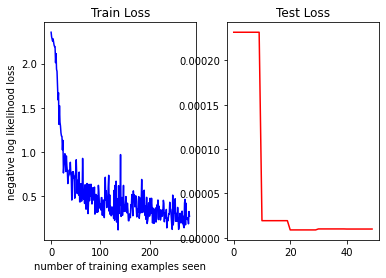

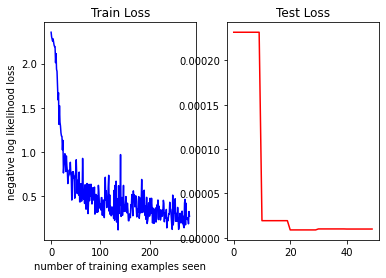

In [ ]:
# mostrem els resultats de classificació un cop entrenat
test()

fig = plt.figure()
plt.subplot(1,2,1)
plt.plot(train_losses, color='blue')

plt.title('Train Loss')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

plt.subplot(1,2,2)
plt.title('Test Loss')
plt.plot(test_losses, color='red')

fig

Finally, we will also show some predictions from 6 samples of one of the test batches. This way, we can have some qualitative results with the visualization of the input image and the category predicted.

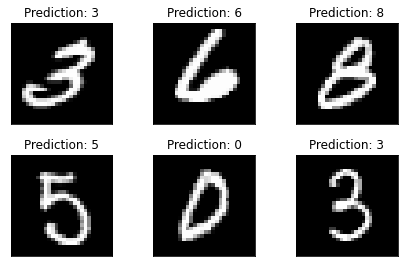

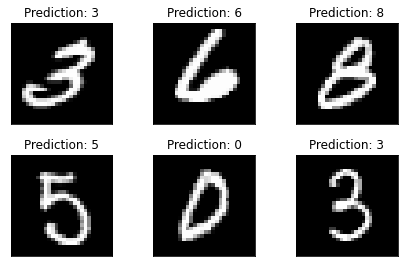

In [ ]:
# classifiquem unes quantes mostres

with torch.no_grad():
  output = network(example_data)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig